In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [11]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from beeid2.models import simple_cnnv2, ContrastiveLearning
from beeid2.data_utils import filename2image
from beeid2.evaluation import mAP_evaluation, mAP_track_model_evaluation, cmc_track_model_evaluation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from tqdm import tqdm
import glob
from skimage import io
def to_np_array(values, dim=128):
    return np.concatenate(list(values)).reshape(-1, dim)


In [3]:
MODEL = "../../models2/2111240952_tagged_augmentataion_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf"

In [4]:
base_model = load_model(MODEL)

In [5]:
def topN_evaluation(model, N=1, timegap=15, timegap_unit="m", batch_size=256):
    test_df = pd.read_csv("/home/jchan/beeid/notebooks/cmc_experiments/data/test_unnormalized.csv")
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    ACCs = list()
    
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    queries_num = 0

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        
        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track) | ~is_same_id]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
            
#         return im_tracks, gallery_df
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = tf.matmul(query, gallery.T)
            distances = np.squeeze(distances.numpy())
#             return distances, labels, query_id
            min_idx = np.argsort(distances)
            
            predicted_ids = labels[min_idx[-N:]]

            acc = np.any(predicted_ids == query_id)
            ACCs.append(acc)
            queries_num += 1
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(ACCs)

In [6]:
topN_evaluation(base_model, N=1, timegap=1, timegap_unit="D")

13/13 [==============================] - 5s 413ms/step


  1%|          | 7/654 [00:00<00:09, 68.84it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 115.53it/s]

Evaluating 1016 queries.


0.4005905511811024

In [7]:
topN_evaluation(base_model, N=1)

13/13 [==============================] - 1s 85ms/step


  0%|          | 0/654 [00:00<?, ?it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:15<00:00, 41.87it/s]

Evaluating 3173 queries.


0.7428301292152537

In [8]:
def get_query_galleries(model, timegap=15, timegap_unit="m", batch_size=256):
    test_df = pd.read_csv("/home/jchan/beeid/notebooks/cmc_experiments/data/test_unnormalized.csv")
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    query_galleries = list()
    
    eval_tracks = len(gtracks)
#     print("Evaluating {} tracks.".format(eval_tracks))
    
    queries_num = 0

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        
        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track) | ~is_same_id]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
            
        query_galleries.append((im_tracks, gallery_df))
    return query_galleries

def plot_query_gallery(query_gallery): 
    q, gallery = query_gallery
    q = q.iloc[0]
    query_id = q.track_tag_id
    query = np.expand_dims(q.emb, axis=0)
    distances = tf.matmul(query, to_np_array(gallery["emb"].values).T)
    distances = np.squeeze(distances.numpy())

    sort_indx = np.argsort(distances)
    qimage = io.imread(q.filename)
    gids = gallery.iloc[sort_indx[-10:]].track_tag_id.values
    gimages =  [io.imread(i) for i in gallery.iloc[sort_indx[-10:]].filename]

    fig, ax = plt.subplots(1, 11, figsize=(30, 20))
    ax[0].imshow(qimage)
    ax[0].set_title(f"query", fontsize=22)
    ax[0].set_xlabel(f"{query_id}", fontsize=22)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    for i in range(10):
        ax[i + 1].set_title(f"gallery", fontsize=22)
        color = "green" if gids[i] == query_id else "red"
        ax[i + 1].set_xlabel(f"{gids[i]}", fontsize=22, color=color)
        ax[i + 1].imshow(gimages[i])
        ax[i + 1].set_xticks([])
        ax[i + 1].set_yticks([])


In [9]:
queryG = get_query_galleries(base_model)

13/13 [==============================] - 1s 83ms/step


100%|██████████| 654/654 [00:02<00:00, 266.32it/s]


In [137]:
q = queryG[0][0].iloc[0]
np.expand_dims(q.emb, axis=0).shape

(1, 128)

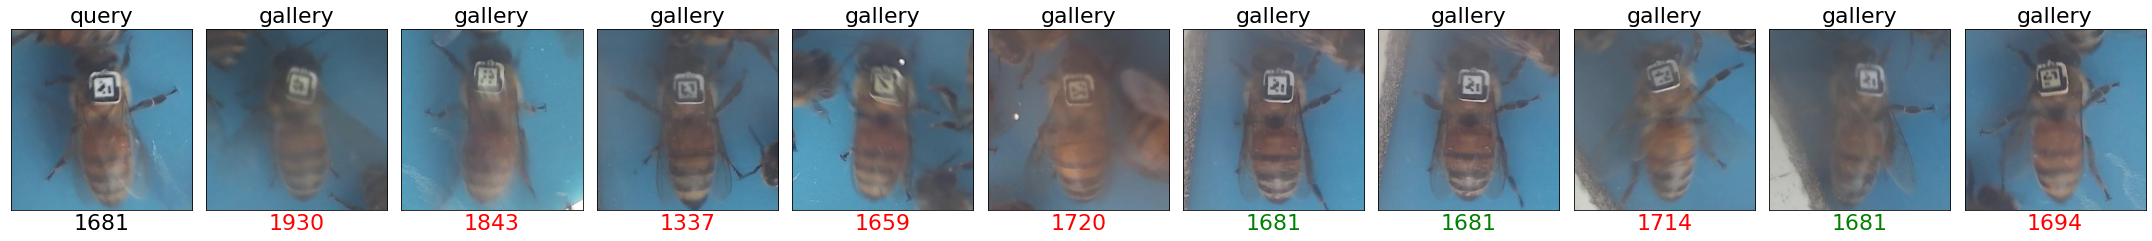

In [17]:
plot_query_gallery(queryG[90])
plt.tight_layout()
plt.savefig("top1_comparison2.png", bbox_inches="tight")

In [6]:
def topN_track_model_evaluation(track_model, N=1, track_len=5, timegap=15, timegap_unit="m", batch_size=64):
    
    # df preprocessing
    test_df = pd.read_csv("/home/jchan/beeid/notebooks/cmc_experiments/data/test_unnormalized.csv")
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])
    
    # filter tracks by minimum len
    tracks = test_df.groupby("global_track_id").filter(lambda x: len(x) >= track_len)
    
    # sample track_len images per track
    tracks = tracks.groupby("global_track_id").sample(track_len).sort_values(["global_track_id", "datetime2"])
    
    tracks_ids = tracks["global_track_id"].values[::track_len]
    track_tag_id = tracks["track_tag_id"].values[::track_len]
    datetime = tracks["datetime2"].values[::track_len]
    filenames = tracks["filename"].values
    images = filename2image(filenames)
    predictions = track_model.predict(images.batch(track_len).batch(batch_size), verbose=True)
    tracks_emb = pd.DataFrame({"datetime": datetime, "track_tag_id":track_tag_id, "global_track_id": tracks_ids, "emb": list(predictions)})
    
    eval_tracks = len(tracks_emb)
    print("Evaluating {} tracks.".format(eval_tracks))
    
    # filtering those ids that at least have 2 tracks
    selected_track_tag_id = tracks_emb.track_tag_id.value_counts()[(tracks_emb.track_tag_id.value_counts() > 1)].index
    gtracks = tracks_emb[tracks_emb.track_tag_id.isin(selected_track_tag_id)].global_track_id.unique()
    
    ACCs = list()
    
    queries_num = 0
    for gtrack in gtracks:
        is_same_track = (tracks_emb.global_track_id == gtrack)
        query_row = tracks_emb[is_same_track].iloc[0]
        
        is_same_id = (query_row.track_tag_id == tracks_emb.track_tag_id)
        is_enough_timegap = np.abs(tracks_emb.datetime - query_row.datetime).astype('timedelta64[{}]'.format(timegap_unit)) > timegap
        gallery_df = tracks_emb[(is_enough_timegap & is_same_id & ~is_same_track) | ~is_same_id]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue
        gallery = to_np_array(gallery_df["emb"].values)
        labels = gallery_df.track_tag_id.values

        query_id = query_row.track_tag_id
        query = np.expand_dims(query_row.emb, axis=0)
        distances = tf.matmul(query, gallery.T)
        distances = np.squeeze(distances.numpy())

        min_idx = np.argsort(distances)

        predicted_ids = labels[min_idx[-N:]]

        acc = np.any(predicted_ids == query_id)
        ACCs.append(acc)
        queries_num += 1
        
    print("Evaluating {} queries.".format(queries_num))
    return np.mean(ACCs)

In [7]:
N=1

In [11]:
TRACK_LEN=4
# base_model = load_model(MODEL)
track_model = tf.keras.Sequential()
track_model.add(tf.keras.layers.TimeDistributed(base_model, input_shape=(TRACK_LEN, 56, 56, 3)))
track_model.add(tf.keras.layers.Lambda(lambda x: tf.math.reduce_mean(x, axis=1)))
track_model.summary()

topN_track_model_evaluation(track_model, N=N, track_len=TRACK_LEN, timegap=15, timegap_unit="m")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 4, 128)            1815040   
_________________________________________________________________
lambda_1 (Lambda)            (None, 128)               0         
Total params: 1,815,040
Trainable params: 1,814,336
Non-trainable params: 704
_________________________________________________________________
4/4 [==============================] - 0s 123ms/step
Evaluating 228 tracks.
Evaluating 198 queries.


0.8434343434343434

In [12]:
topN_track_model_evaluation(track_model, N=N, track_len=TRACK_LEN, timegap=1, timegap_unit="D")

4/4 [==============================] - 0s 85ms/step
Evaluating 228 tracks.
Evaluating 43 queries.


0.5581395348837209

In [8]:
TRACK_LEN=4
batch_size = 1

def random_sampling(x):
    rand_idx = tf.random.uniform(shape=[], maxval=TRACK_LEN, dtype=tf.int32)
    return x[:, rand_idx, :]
    

# base_model = load_model(MODEL)
track_rand_model = tf.keras.Sequential()
track_rand_model.add(tf.keras.layers.TimeDistributed(base_model, input_shape=(TRACK_LEN, 56, 56, 3)))
track_rand_model.add(tf.keras.layers.Lambda(random_sampling))
track_rand_model.summary()

topN_track_model_evaluation(track_rand_model, N=N, track_len=TRACK_LEN, timegap=15, timegap_unit="m", batch_size=batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 4, 128)            1815040   
_________________________________________________________________
lambda_2 (Lambda)            (None, 128)               0         
Total params: 1,815,040
Trainable params: 1,814,336
Non-trainable params: 704
_________________________________________________________________
228/228 [==============================] - 1s 2ms/step
Evaluating 228 tracks.
Evaluating 198 queries.


0.7121212121212122

In [9]:
topN_track_model_evaluation(track_rand_model, N=N, track_len=TRACK_LEN, timegap=1, timegap_unit="D", batch_size=batch_size)

228/228 [==============================] - 1s 3ms/step
Evaluating 228 tracks.
Evaluating 43 queries.


0.46511627906976744